In [1]:
import pandas as pd
import seaborn as sns
import os
import torch
import numpy as np
import math
import tensorflow as tf
from sklearn import ensemble
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

# Read in the data and preform the transformation to prepare for analysis

In [ ]:
df= pd.read_pickle('df.pkl')

In [2]:
# Custom Transforms

class fix_percent(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass 
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y=None):
        _X = X.copy()
        
        for i in X.columns:
            _X[i] = _X[i].str.replace('%', '').astype(float)/100
        return _X

In [3]:
def time_def(x):
    return (relativedelta(datetime.now(), pd.to_datetime(x)).years)
# custom transform for earliest credit line

class time_passed(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass 
    
    def fit(self, X, y = None):
        return self
   
    def transform(self, X, y=None):
        _X = X.copy()       
        for i in X.columns:
            _X[i] = _X[i].apply(lambda x: time_def(x))
        return _X

In [4]:
def make_target(val):
    if val in ['Charged Off', 'Late (31-120 days)', 'Default']:
        return 1
    else:
        return 0

In [ ]:
features = ['loan_amnt'
            , 'term'
            , 'int_rate'
            , 'installment'
            , 'grade'
            , 'sub_grade'
            , 'emp_title'
            , 'emp_length'
            , 'home_ownership'
            , 'annual_inc'
            , 'verification_status'
            , 'purpose'
            , 'title'
            , 'addr_state'
            , 'dti'
            , 'delinq_2yrs'
            , 'earliest_cr_line'
            , 'fico_range_low'
            , 'fico_range_high'
            , 'inq_last_6mths'
            , 'mths_since_last_delinq'
            , 'mths_since_last_record'
            , 'open_acc'
            , 'pub_rec'
            , 'revol_bal'
            , 'revol_util'
            , 'total_acc'
            , 'initial_list_status'
            , 'loan_status']

status_list = ['Fully Paid', 'Charged Off', 'Late (31-120 days)', 'Default']
df = df[df['loan_status'].isin(status_list)]
df['loan_status'] = df['loan_status'].apply(make_target)
df = df[features]

In [6]:
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Features that we want to leave untransformed:
# Only numeric features need apply:
standardize_and_impute_only = [
'loan_amnt'
, 'annual_inc'
, 'delinq_2yrs'
, 'inq_last_6mths'
, 'open_acc'
]

# maybe we will trying some polynomial transofmrations
polynomial_features = [
'installment'
, 'dti'
]

# how about some discretizations?
discretization = [
'fico_range_low'
, 'fico_range_high'
, 'mths_since_last_delinq'
, 'mths_since_last_record'
, 'pub_rec'
, 'revol_bal'
, 'total_acc'
]

# let's construct all of our transformers
standard_scaler = StandardScaler()
missing_indicator = MissingIndicator(features="all")
simple_imputer = SimpleImputer(strategy='median')
polynomial_featurizer = PolynomialFeatures(2)
discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform')
fix_percent_transformer = fix_percent()

# and make the pipelines
standardize_and_impute_pipeline_steps = [('standardization', standard_scaler), ('imputer', simple_imputer)]
standardize_and_impute_pipeline = Pipeline(standardize_and_impute_pipeline_steps)

polynomial_pipeline_steps = standardize_and_impute_pipeline_steps + [('polynomial', polynomial_featurizer)]
polynomial_pipeline = Pipeline(polynomial_pipeline_steps)

discretize_steps = [('imputer', simple_imputer), ('discretize', discretizer)]
discretize_pipeline = Pipeline(discretize_steps)

interest_rate_steps = [('fix_int_rate', fix_percent_transformer)] + standardize_and_impute_pipeline_steps
interest_rate_pipeline = Pipeline(interest_rate_steps)

missing_flag_steps = [('missing_flag', missing_indicator)]
missing_flag_pipeline = Pipeline(missing_flag_steps)

#now we can use a ColumnTransformer to do everything
transform_pipeline = ColumnTransformer([
    ('standardize_and_impute_pipeline', standardize_and_impute_pipeline, standardize_and_impute_only)
     , ('polynomial_pipeline', polynomial_pipeline, polynomial_features)
     , ('discretize_pipeline', discretize_pipeline, discretization)
     , ('interest_rate_pipeline', interest_rate_pipeline, ['int_rate'])
     , ('missing_flag_pipeline', missing_flag_pipeline, standardize_and_impute_only + polynomial_features + discretization)
])


# Test train

We took a sample of 3000 positive cases and 7000 negetive cases from the total data frame for studying.

In [127]:
small_df_1 = df[df['loan_status']==1].sample(n=3000)
small_df_0 = df[df['loan_status']==0].sample(n=7000)
small_df = small_df_1.append(small_df_0, ignore_index=True)

In [2]:
small_df= pd.read_pickle('small_df.pkl')

In [8]:
X = small_df.drop(['loan_status'], axis = 1)
y = small_df[['loan_status']]

In [9]:
small_df['loan_status'].value_counts()

0    7000
1    3000
Name: loan_status, dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [11]:
X_train = transform_pipeline.fit_transform(X_train)
X_test = transform_pipeline.fit_transform(X_test)

# Model

For this project we studied deep learning and implemented what we learned into the following neural netwrok. Our main focuse for thsi project was to find how to best optimize our hyperperameters to increase the acuracy and recal of our models to best predict loans that would defaualt.

## Model without weight

In [35]:
# Creating the neaural net
def define_model():
    model = Sequential()

    model.add(Dense(units=50,activation='relu')) # Relu is an activation function that activates when value is more than 1 but counts any value less than zero as zero
    model.add(Dropout(0.2))
    
    model.add(Dense(units=30,activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=20,activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=30,activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(units=1,activation='sigmoid')) # sigmoid is an activation function that gives an output between 0 and 1
        
    model.compile(loss='binary_crossentropy', optimizer='adam') #Adam is teh algorithem used to optimize our model by changing the weights during training
    
    return(model)

model = define_model()

In [36]:
import time
start = time.time()

model.fit(x=X_train,
          y=y_train, 
          epochs=300,# how many times we train our model
          validation_split=0.2,
          verbose=0,# to either diplay training epochs or not
          workers=2) # CPU usage perameter in training
         
endtime = time.time()-start 

In [37]:
endtime/60

0.7959522485733033

In [38]:
# turn array rsult into dataframe
model_loss = pd.DataFrame(model.history.history)

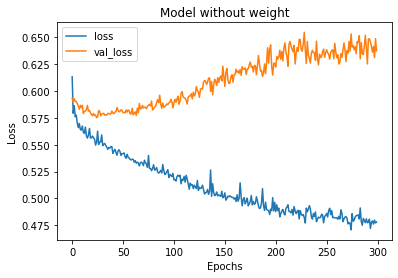

In [39]:
#drawing teh result of the loass from each epoch during our training
loss_values = model.history.history['loss'] 
epochs = range(1, len(loss_values)+1)
model_loss[['loss','val_loss']].plot()
plt.title('Model without weight')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('withoutweight.jpeg')
plt.legend()

plt.show()

In [40]:
ynew = model.predict_classes(X_test) # predicting test set using our trained mdoel
#dispalying teh confusion matrix and other accuracy messures
recall_score(y_test,ynew)
score = roc_auc_score(y_test, ynew)
tn, fp, fn, tp = confusion_matrix(y_test,ynew).ravel()
print(" ")
print(f"CM {('tn', 'fp', 'fn','tp')}")
print(f"CM {(tn, fp, fn, tp)}")
print(" ")
print(classification_report(y_test,ynew))
print(" ")
print('ROC AUC: %.3f' % score)

 
CM ('tn', 'fp', 'fn', 'tp')
CM (1139, 252, 387, 222)
 
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      1391
           1       0.47      0.36      0.41       609

    accuracy                           0.68      2000
   macro avg       0.61      0.59      0.60      2000
weighted avg       0.66      0.68      0.67      2000

 
ROC AUC: 0.592


## Model with weight

For this model we tried using the weight perameter in model to train our model better with the imbalanced classes. we discovered that even tho our model is not preforming better in accuracy the recal has improved significantly. we tried many different weight ratios and after running the model with different weights we set the values as 0.35 and 0.65, we concluded that even with similar accuracy this model would be bette roption between the two models sine it calssifies defulted loans better.

In [41]:
def define_model2():
    model2 = Sequential()

    model2.add(Dense(units=50,activation='relu'))
    model2.add(Dropout(0.2))
    
    model2.add(Dense(units=30,activation='relu'))
    model2.add(Dropout(0.2))
    
    model2.add(Dense(units=20,activation='relu'))
    model2.add(Dropout(0.2))
    
    model2.add(Dense(units=30,activation='relu'))
    model2.add(Dropout(0.2))

    model2.add(Dense(units=1,activation='sigmoid'))
        
    model2.compile(loss='binary_crossentropy', optimizer='adam')
    
    return(model2)

model2 = define_model2()

In [47]:
import time
start = time.time()

model2.fit(x=X_train,
          y=y_train, 
          epochs=300,
           validation_split=0.2,
           class_weight={0:0.35,1:0.65},# we assigned more weight to the the minority class to counter the imbance data
           verbose=0,
           workers=2)

endtime = time.time()-start 

In [48]:
endtime/60

0.8769070188204448

In [49]:
model2_loss = pd.DataFrame(model2.history.history)

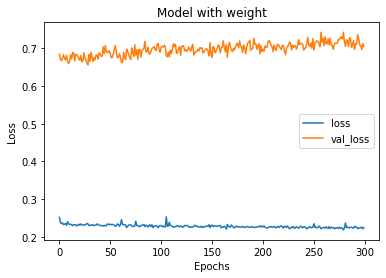

In [50]:
loss_values2 = model2.history.history['loss']
epochs = range(1, len(loss_values)+1)

model2_loss[['loss','val_loss']].plot()
plt.title('Model with weight')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('withweight.jpeg')
plt.show()

In [51]:
ynew2 = model2.predict_classes(X_test)
recall_score(y_test,ynew2)
tn2, fp2, fn2, tp2 = confusion_matrix(y_test,ynew2).ravel()
print(" result with weight ")
print(f"CM {('tn','fp','fn','tp')}")
print(f"CM {(tn2, fp2, fn2, tp2)}")
print(" ")
print(classification_report(y_test,ynew2))

 result with weight 
CM ('tn', 'fp', 'fn', 'tp')
CM (907, 484, 286, 323)
 
              precision    recall  f1-score   support

           0       0.76      0.65      0.70      1391
           1       0.40      0.53      0.46       609

    accuracy                           0.61      2000
   macro avg       0.58      0.59      0.58      2000
weighted avg       0.65      0.61      0.63      2000



In [57]:
ynew = model.predict_classes(X_test)
recall_score(y_test,ynew)
tn, fp, fn, tp = confusion_matrix(y_test,ynew).ravel()
print(" Result without weight")
print(f"CM {('tn','fp','fn','tp')}")
print(f"CM {(tn, fp, fn, tp)}")
print(" ")
print(classification_report(y_test,ynew))

 Result without weight
CM ('tn', 'fp', 'fn', 'tp')
CM (1120, 271, 391, 218)
 
              precision    recall  f1-score   support

           0       0.74      0.81      0.77      1391
           1       0.45      0.36      0.40       609

    accuracy                           0.67      2000
   macro avg       0.59      0.58      0.58      2000
weighted avg       0.65      0.67      0.66      2000



In [243]:
ynew = model.predict(X_test) #prediction without weight

In [246]:
ynew2 = model2.predict(X_test) # prediction with weight

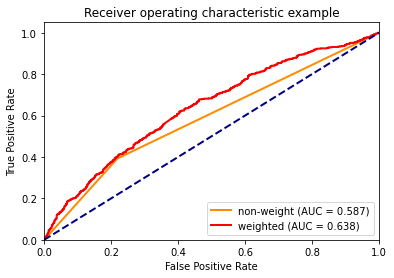

In [261]:
gbc_fpr, gbc_tpr, gbc_thresholds = roc_curve(y_test, ynew)
# Compute ROC curve for the model without weight 
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, ynew2)
# Compute ROC curve for the model with weight 
gbc_roc_auc = auc(gbc_fpr,gbc_tpr)
rf_roc_auc  = auc(rf_fpr, rf_tpr)
plt.figure()
lw = 2
plt.plot(gbc_fpr,gbc_tpr, color='darkorange',
         lw=lw, label='non-weight (AUC = %0.3f)' % gbc_roc_auc)
plt.plot(rf_fpr, rf_tpr, color='red',
         lw=lw, label='weighted (AUC = %0.3f)' % rf_roc_auc)
plt.plot()
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('roc.png')
plt.show()